# XAI CODE DEMO

## Explainable AI Specialization on Coursera

# Saliency Maps 🖼️

If you experience high latency while running this notebook, you can open it in Google Colab:

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/explainable-machine-learning/explainable-ml/blob/main/saliency_maps.ipynb)

Pixel attribution highlights the pixels relevant to an image classification by a neural network. Visualizations via the vanilla gradient are also known as saliency maps.

### How does it work?
Calculate the gradient of the loss function for the class of interest with respect to the input pixels

Process:
1. Perform a forward pass of image of interest
2. Compute the gradient of the class score of interest with respect to the input pixels (set all other classes to zero)
3. Visualize the gradients (show absolute values or highlight negative and positive contributions)


In [1]:
!pip install numpy==1.25.2 matplotlib==3.7.1 tensorflow==2.14.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 146.4 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 184.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 168.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 148.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 181.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 115.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 203.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 137.6 MB/s eta 0:00:00
   ━

Note: When you run the code block below, you may get a warning "Cannot find TensorRT". Don't worry about this, it is only required if you need a GPU, which this lab does not need.

In [2]:
# Basic
import numpy as np
import matplotlib.pyplot as plt

# Model Utils
import tensorflow as tf

# Data Utils
from tensorflow.keras.preprocessing import image
from keras.utils import get_file
import json

2025-02-23 11:02:20.944121: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-23 11:02:21.011023: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-23 11:02:21.011080: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-23 11:02:21.011182: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-23 11:02:21.036422: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-23 11:02:21.037569: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

#### Tensorflow Terminology: gradient tape

A **gradient tape** is a TensorFlow mechanism for automatic differentiation. We use it to record operations for which we want to compute gradients, typically within the context of training a neural network. When we perform operations inside a tf.GradientTape() context, TensorFlow keeps track of all the computations that occur on tensors that are "watched" by the tape.

Here gradient tape is used to compute the gradients of the model's predictions with respect to the input image tensor.

In [4]:
# Function to generate a saliency map for an input image based on a given model

def generate_saliency_map(model, img):
    # Convert the input image to a TensorFlow variable
    x = tf.Variable(img)

    # Add an extra dimension to the image tensor to match the model's input shape
    x = tf.expand_dims(x, axis=0)

    # Preprocess the image according to ResNet50 requirements
    x = tf.keras.applications.resnet50.preprocess_input(x)

    # Create a gradient tape context to record operations for automatic differentiation
    with tf.GradientTape() as tape:
        # Watch the input tensor to calculate gradients
        tape.watch(x)

        # Forward pass: get model predictions for the input image
        preds = model(x)

        # Find the index of the highest predicted class probability
        top_pred_index = tf.argmax(preds[0])

    # Calculate the gradients of the top prediction with respect to the input image
    grads = tape.gradient(preds, x)

    # Compute the saliency map by taking the maximum absolute gradient across color channels
    saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0]

    # Return the saliency map and the index of the top predicted class as a numpy array
    return saliency, top_pred_index.numpy()


We will load a pre-trained model, [ResNet50](https://www.tensorflow.org/api_docs/python/tf/keras/applications/ResNet50)

and a test image from the [ImageNetV2](https://www.tensorflow.org/datasets/catalog/imagenet_v2) dataset



In [5]:
# Load ResNet50 pre-trained model
model = tf.keras.applications.ResNet50(weights='imagenet', include_top=True)

102967424/102967424 [==============================] - 1s 0us/step


The following codeblock can be used outside of the Coursera lab environment to load the ImageNetV2 dataset. We have pre-saved an image and label for you to use for the remainder of the code. 

Load pre-saved image, label, and class labels for ImageNet. If this notebook is run outside of the Coursera Labs environment, this code can be removed.

In [15]:
index = 1 #available indices: 1, 4, 5, 10, 15

# Load the image and label
img = np.load(f'image_{index}.npy')
label = np.load(f'label_{index}.npy')

# Load the ImageNet class labels
with open('imagenet_class_index.json') as f:
    class_idx = json.load(f)

print("Image shape:", img.shape)
print("Label:", label)
print("Class index:", class_idx)

Image shape: (224, 224, 3)
Label: 742
Class index: {'0': ['n01440764', 'tench'], '1': ['n01443537', 'goldfish'], '2': ['n01484850', 'great_white_shark'], '3': ['n01491361', 'tiger_shark'], '4': ['n01494475', 'hammerhead'], '5': ['n01496331', 'electric_ray'], '6': ['n01498041', 'stingray'], '7': ['n01514668', 'cock'], '8': ['n01514859', 'hen'], '9': ['n01518878', 'ostrich'], '10': ['n01530575', 'brambling'], '11': ['n01531178', 'goldfinch'], '12': ['n01532829', 'house_finch'], '13': ['n01534433', 'junco'], '14': ['n01537544', 'indigo_bunting'], '15': ['n01558993', 'robin'], '16': ['n01560419', 'bulbul'], '17': ['n01580077', 'jay'], '18': ['n01582220', 'magpie'], '19': ['n01592084', 'chickadee'], '20': ['n01601694', 'water_ouzel'], '21': ['n01608432', 'kite'], '22': ['n01614925', 'bald_eagle'], '23': ['n01616318', 'vulture'], '24': ['n01622779', 'great_grey_owl'], '25': ['n01629819', 'European_fire_salamander'], '26': ['n01630670', 'common_newt'], '27': ['n01631663', 'eft'], '28': ['n016

In [16]:
# Generate saliency map
saliency_map, top_pred_index = generate_saliency_map(model, img)

# Map the index to class label
predicted_class = class_idx[str(top_pred_index)][1]

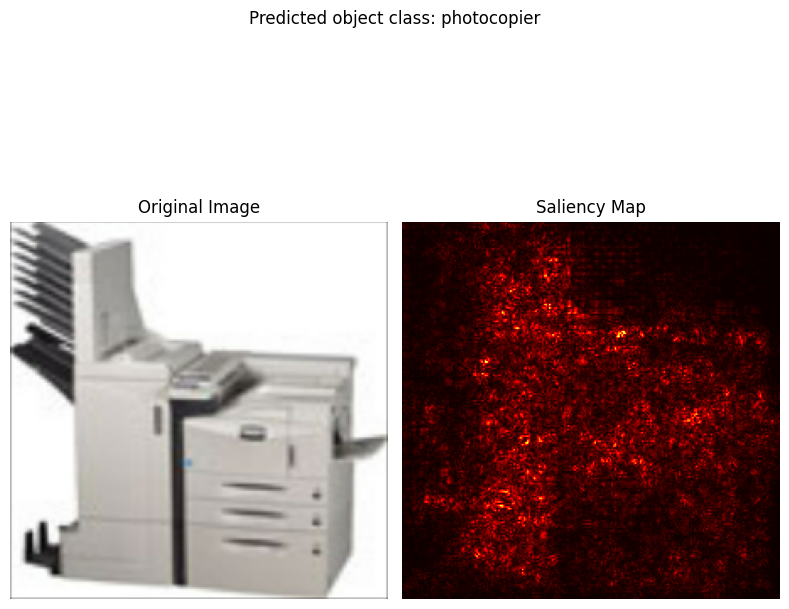

In [22]:
# Display the original image
plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img.astype(np.uint8))
plt.axis('off')
plt.tight_layout()

# Display the saliency map
plt.subplot(1, 2, 2)
# plt.imshow(saliency_map, cmap='viridis')
plt.imshow(saliency_map, cmap='hot')
plt.title("Saliency Map")
plt.suptitle(f"Predicted object class: {predicted_class}")
plt.axis('off')
plt.tight_layout()

plt.show()

In [18]:
predicted_class

'photocopier'

# SmoothGrad

In [19]:
import numpy as np
import matplotlib.pyplot as plt

In [20]:
def smooth_grad(model, img, num_samples=50, noise_level=0.1):
    """
    Generate a SmoothGrad Saliency Map to reduce noise and improve interpretability.

    Parameters:
    - model: Pretrained neural network model
    - img: Input image (shape: [224, 224, 3])
    - num_samples: Number of noise samples (default: 50)
    - noise_level: Standard deviation of the noise added to the image (default: 0.1)

    Returns:
    - Smoothed Saliency Map (shape: [224, 224])
    """
    smooth_saliency = np.zeros((img.shape[0], img.shape[1]))  # Initialize as (224, 224)

    for _ in range(num_samples):
        noise = np.random.normal(0, noise_level, img.shape)  # Add random noise
        noisy_img = img + noise  # Generate a noisy image
        saliency, _ = generate_saliency_map(model, noisy_img)  # Compute Saliency Map
        smooth_saliency += saliency  # Accumulate results

    return smooth_saliency / num_samples  # Compute the average


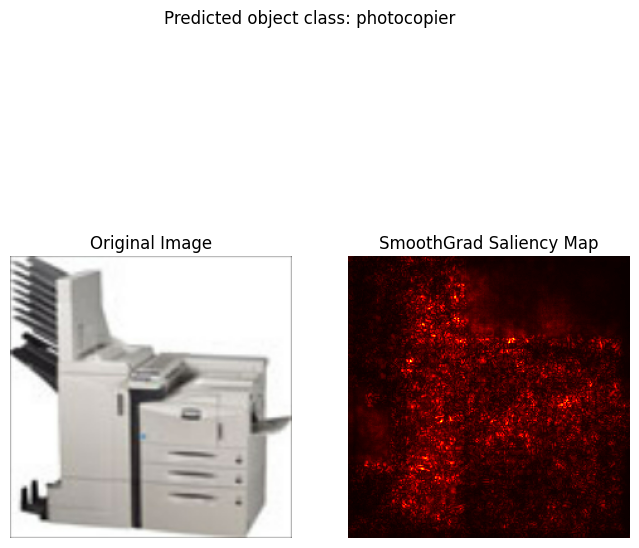

In [23]:
# Generate SmoothGrad Saliency Map
smooth_saliency_map = smooth_grad(model, img)

# Display the results
plt.figure(figsize=(8, 8))

# Show the original image
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img.astype(np.uint8))
plt.axis("off")

# Show the SmoothGrad Saliency Map
plt.subplot(1, 2, 2)
plt.imshow(smooth_saliency_map, cmap='hot')
plt.title("SmoothGrad Saliency Map")
plt.suptitle(f"Predicted object class: {predicted_class}")
plt.axis("off")

plt.show()